# 1. 데이터 읽기

기상자료개방포털의 **동네예보 > 초단기실황** 데이터를 크롤러를 만들어 2019.08~2021.08 데이터를 수집하였다. 지역의 범위는 이어도를 제외한 전체지역이다.

In [3]:
import os
import glob 
import pandas as pd
import numpy as np

## 1.1 데이터 불러오기

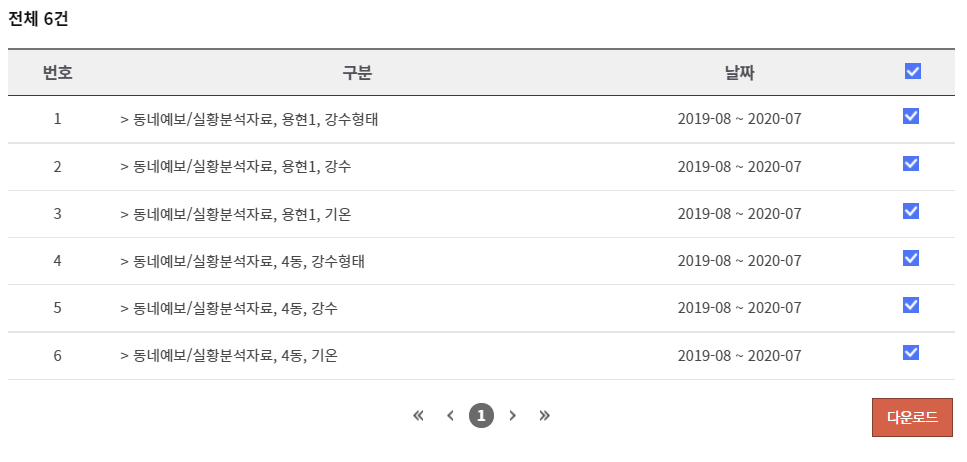

원래의 계획은 이렇게 다운받은 데이터를 구글 클라우드에 올리고, 코랩에서 압축두번 풀고 바로 작업하는 것이었다. 그러나 기상자료개방포털에서 위와같이 파일이름이 ,로 구분됨에 따라(다운로드 하면 _로 바뀐다) 숭의 1,3동/도화2,3동/용현1,4동 과 같이 ,로 구분된 지역이 파일이 나뉘어 게재되고, 다운로드 되었다. 실제 데이터는 4동과 같이 뒷부분 이름에만 들어있다. 코랩에서는 이것을 파악하기 어려워서 윈도우에서 압축을 풀고 파일명을 바꾸거나 몇개의 파일을 삭제한 뒤 csv파일만 남긴 후 압축하여 구글 드라이브로 다시 업로드 하였다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#우분투에서 다운받아 파일이름의 한글이 깨지므로 압축을 해제할 때 인코딩을 지정해주자.
!unzip -O cp949 '/content/drive/MyDrive/weathers.zip' -d '/content/'

Archive:  /content/drive/MyDrive/weathers.zip
replace /content/weathers/가경동_강수_201908_202007.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
file_list = glob.glob('/content/weathers/*.csv')
print(file_list[0])
len(file_list)

/content/weathers/가천면_강수_201908_202007.csv


31596

In [7]:
rain_list=[]
temp_list=[]
rainSnow_list=[]


for fname in file_list:
  # print(fname)
  if len(fname.split("_"))>4: #대정읍_마라도포함_강수_201908_202007 (9개존재)
    if fname.split("_")[2].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[2].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[2].endswith('강수'):
      rain_list.append(fname)
  else:
    if fname.split("_")[1].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[1].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[1].endswith('강수'):
      rain_list.append(fname)
  


총 31590개의 데이터가 필요한데 내가 다운받으면서 6개가 중복으로 들어간것 같다. </br>
31590/3 = 10530 개씩 강수, 강수형태, 기온 데이터가 존재해야하는데 부족하지 않으므로 나중에 duplicate로 살펴보는 것으로 하자.

In [8]:
print("rain_list",len(rain_list))
print("temp_list",len(temp_list))
print("rainSnow_list",len(rainSnow_list))
temp_list[-20:]

rain_list 10532
temp_list 10533
rainSnow_list 10531


['/content/weathers/신당동_기온_201908_202007.csv',
 '/content/weathers/금강송면_기온_201908_202007.csv',
 '/content/weathers/대청동_기온_202008_202107.csv',
 '/content/weathers/동백3동_기온_201908_202007.csv',
 '/content/weathers/능곡동_기온_202108_202108.csv',
 '/content/weathers/화서1동_기온_201908_202007.csv',
 '/content/weathers/연지동_기온_201908_202007.csv',
 '/content/weathers/성덕동_기온_202008_202107.csv',
 '/content/weathers/고한읍_기온_202008_202107.csv',
 '/content/weathers/복산1동_기온_202008_202107.csv',
 '/content/weathers/시기동_기온_202108_202108.csv',
 '/content/weathers/동송읍_기온_201908_202007.csv',
 '/content/weathers/청라1동_기온_201908_202007.csv',
 '/content/weathers/개포면_기온_201908_202007.csv',
 '/content/weathers/황성동_기온_202008_202107.csv',
 '/content/weathers/불당동_기온_202008_202107.csv',
 '/content/weathers/등촌제2동_기온_201908_202007.csv',
 '/content/weathers/온정면_기온_201908_202007.csv',
 '/content/weathers/괘법동_기온_201908_202007.csv',
 '/content/weathers/도곡2동_기온_202108_202108.csv']

In [ ]:
for item in rain_list:
  if item.split("_")[0].endswith('용현1,4동'):
    print(item)

/content/weathers/용현1,4동_강수_202108_202108.csv
/content/weathers/용현1,4동_강수_202008_202107.csv
/content/weathers/용현1,4동_강수_201908_202007.csv


## 1.2 데이터 파악하기

* 첫번째 열 이름은 ' format: day'이고 마지막 열 이름은 'value location:81_91 Start : 20190801 '이다. **공백 주의**.
* value_location의 값은 **격자 X_격자 Y**값이다.
* 첫 시작일은 'value location:81_91 Start : 20190801 '에서 얻을 수 있고, day가 마지막 날이 되면 ' format: day'에 'Start : 20190901' 형태로 다음달 첫날 등장한다.

In [ ]:
sample = pd.read_csv('/content/weathers/가천면_강수_201908_202007.csv')
sample

,format: day,hour,value location:81_91 Start : 20190801
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0
...,...,...,...
8790,31,1900.0,0.0
8791,31,2000.0,0.0
8792,31,2100.0,0.0
8793,31,2200.0,0.0


In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0    format: day                            8795 non-null   object 
 1   hour                                    8784 non-null   float64
 2   value location:81_91 Start : 20190801   8784 non-null   float64
dtypes: float64(2), object(1)
memory usage: 206.3+ KB


In [ ]:
sample.columns

Index([' format: day', 'hour', 'value location:81_91 Start : 20190801 '], dtype='object')

In [ ]:
sample[740:750]

,format: day,hour,value location:81_91 Start : 20190801
740,31,2000.0,0.0
741,31,2100.0,0.0
742,31,2200.0,0.0
743,31,2300.0,0.0
744,Start : 20190901,NaN,NaN
745,1,0.0,0.0
746,1,100.0,0.0
747,1,200.0,0.0
748,1,300.0,0.0
749,1,400.0,0.0


> 마지막에는 **outer join으로 합치기!**
http://www.gisdeveloper.co.kr/?p=8255

# 2. 데이터프레임으로 만들기

csv파일은 아래와 같이 날짜에는 1~ 마지막날까지 써있고 각 일자별로 0~23시까지 시간대별로 데이터가 존재한다. 한달단위로 데이터가 쓰여진 뒤에는 `Start : 20201001`처럼 날짜 열에 다음달의 시작일자가 등장한다. </br>
이것을 이제 배달데이터 처럼 **날짜를 년과 달을 붙여서 나타내고**, 이 데이터에는 지역이 적혀있지 않으니 새롭게 **읍면동, 격자X, 격자 Y라는 열을 만들어** 데이터를 넣어줄 것이다. 문제는 데이터가 너무나 많아서 3가지 방법 중 **어떤 방법으로 시도해도 램이 감당하지 못하고 터져버리는 것**이다. 어떻게 해결하면 좋을까?

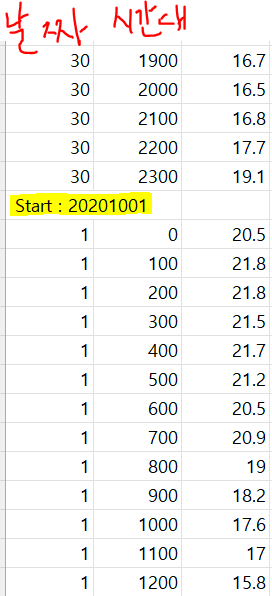

In [ ]:
location = pd.read_excel('/content/drive/MyDrive/기상청41_단기예보 조회서비스_오픈API활용가이드_격자_위경도(20210401).xlsx', engine='openpyxl')
location

,구분,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100),위치업데이트,Unnamed: 16
0,kor,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569,NaN,NaN
1,kor,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378,NaN,NaN
2,kor,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137,NaN,NaN
3,kor,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269,NaN,NaN
4,kor,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,kor,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475,NaN,NaN
3770,kor,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178,NaN,NaN
3771,kor,5013062000,제주특별자치도,서귀포시,예래동,50,32,126,23,59.67,33,15,3.69,126.399908,33.251025,NaN,NaN
3772,kor,5019000000,이어도,NaN,NaN,28,8,0,0,0.00,0,0,0.00,0.000000,0.000000,NaN,NaN


## 방법1. 루프를 돌때마다 concat으로 합쳐주기

### **절대! 금지!** 하루종일해도 결과를 얻을 수 없다.

In [ ]:
rain_df = pd.DataFrame(columns=['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y'])

In [ ]:
rain_df

,날짜,시간대,읍면동,강수,격자 X,격자 Y


데이터프레임을 일일히 읽어서 합치는것은 매우 오래 걸리므로 다른 곳으로 이동하고 싶다면 중간에 코랩의 런타임을 유지시키기 위해 F12를 눌러 콘솔에
아래의 코드를 붙여넣고 엔터를 누르자. 30분에 한번씩 코랩의 툴바가 클릭될 것이다.

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 1800000)
```




In [ ]:
for fname in rain_list:
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    df.loc[i,'날짜'] = start_date + df.loc[i,'날짜'] #이부분이 시간이 가장 오래걸림!
  
  '''재정렬 및 합치기'''
  df = df[['날짜', '시간대', '읍면동', '강수','격자 X','격자 Y']]
  rain_df = pd.concat([rain_df, df], ignore_index=True)

'''날짜 col 정제'''
rain_df = rain_df.drop(rain_df[rain_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rain_df['날짜'] = pd.to_datetime(rain_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대바꾸기'''
rain_df= rain_df.astype({'시간대': 'int'}) 
rain_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rain_df['시간대']]

rain_df  

In [ ]:
rain_df.to_csv('/content/drive/MyDrive/강수_2019_2021.csv',index=False, encoding="utf-8-sig")
rain_df.to_excel('/content/drive/MyDrive/강수_2019_2021.xlsx',index=False, encoding="utf-8-sig")

> 메모리 덜 쓰고 Pandas DataFrame 병합을 빠르게 하는 방법(여러 개의 용량 큰 파일) : https://emilkwak.github.io/pandas-dataframe-concat-efficiently

나는 그런데 그대로 병합하면 안되고, 각 프레임별로 읍면동, 격자X, 격자 Y데이터를 함께 붙여야 한다.

## 방법 2. 모든 데이터를 리스트에 각각 담아서 열로 붙이기

완료되기까지 **50분**이 걸리지 않지만...저장하고있는 리스트가 너무 많아서 코랩의 일반유저는 **램**이 한정되어 있어서 **램이 꽉차서** 세션이 다운되고 **런타임이 초기화**된다...

In [11]:
temp_df = pd.DataFrame(columns=['날짜', '시간대','읍면동', '기온','격자X','격자Y'])
temp_df

,날짜,시간대,읍면동,기온,격자X,격자Y


In [12]:
date=[]
level3_list=[]
x=[]
y=[]
hour=[]
temp=[]

for j,fname in enumerate(temp_list):
  print(j)
  df = pd.read_csv(fname)

  '''필요한 날짜, 격자X, 격자 Y, 읍면동 정보 얻기'''
  start_date = df.columns[-1].strip()[-8:-2]
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼명 재정의'''
  df.columns = ['날짜','시간대','기온']
  
  '''Start검색을 위해 날짜 컬럼 string 타입으로 변경'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    date.append(start_date + df.loc[i,'날짜'])
    level3_list.append(level3)
    x.append(xy[0])
    y.append(xy[1])
    hour.append(df.loc[i,'시간대'])
    temp.append(df.loc[i,'기온'])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725

In [ ]:
'''데이터 프레임의 열로 합치기'''
temp_df['날짜'] = date
temp_df['시간대'] = hour
temp_df['읍면동'] = level3_list
temp_df['기온'] = temp
temp_df['격자X'] = x
temp_df['격자Y'] = y

'''날짜 col 정제'''
# temp_df = temp_df.drop(temp_df[temp_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
temp_df['날짜'] = pd.to_datetime(temp_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
temp_df= temp_df.astype({'시간대': 'int'}) 
temp_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in temp_df['시간대']]

temp_df 

In [ ]:
temp_df.to_csv('/content/drive/MyDrive/온도_2019_2021.csv',index=False, encoding="utf-8-sig")
temp_df.to_excel('/content/drive/MyDrive/온도_2019_2021.xlsx',index=False, encoding="utf-8-sig")

## 방법3. 데이터프레임을 리스트에 담아서 concat 제대로 활용하기


방법1의 경우 루프를 돌때마다 concat을 사용하는 방법으로 이렇게 concat함수를 동적으로 사용하는 것은 concat의 이점을 리지 못해 append보다 더 오래 걸릴 수 있다. 따라서 결합할 데이터프레임을 먼저 리스트로 모아주고, concat함수에서 이를 인자로 받아 활용하면 더욱 빠르게 데이터프레임을 결합할 수 있다.

이렇게하면 실행시간은 **단 30분!**

In [12]:
rainSnow_df = pd.DataFrame(columns=['날짜', '시간대','읍면동','강수형태','격자X','격자Y'])
rainSnow_df

,날짜,시간대,읍면동,강수형태,격자X,격자Y


In [13]:
concat_list=[]
date=[]
for j,fname in enumerate(rainSnow_list):
  print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수형태']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    # df.loc[i,'날짜'] = start_date + df.loc[i,'날짜']
    date.append(start_date + df.loc[i,'날짜'])
  
  '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
  df = df[['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y']]
  concat_list.append(df)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723

In [14]:
len(date)

64207728

저장하는 과정까지는 램이 넉넉하게 남아있다. 하지만 concat과정에서 램이 꽉차서 세션이 다운된다.

In [ ]:
rainSnow_df = pd.concat(concat_list, ignore_index=True)

'''날짜 col 정제'''
rainSnow_df = rainSnow_df.drop(rainSnow_df[rainSnow_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rainSnow_df['날짜'] = date
rainSnow_df['날짜'] = pd.to_datetime(rainSnow_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
rainSnow_df= rainSnow_df.astype({'시간대': 'int'}) 
rainSnow_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rainSnow_df['시간대']]

rainSnow_df

In [ ]:
rainSnow_df.to_csv('/content/drive/MyDrive/강수형태_2019_2021.csv',index=False, encoding="utf-8-sig")
rainSnow_df.to_excel('/content/drive/MyDrive/강수형태_2019_2021.xlsx',index=False, encoding="utf-8-sig")